# `races_all_entries_nan_value.ipynb`

### Author: Anthony Hein

#### Last updated: 10/19/2021

# Overview:

This notebook is closely related to `get_nan_rpr_or_tr.ipynb`. This addresses the fact that some races may be such that all the RPR/OR/TR values are `NaN` in this race, which would render us unable to fill in an average value to convey the idea of no additional information. If this case is prolific, we will have to drop the column.

---

## Setup

In [1]:
import git
import os
from typing import List
from collections import defaultdict
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
BASE_DIR = git.Repo(os.getcwd(), search_parent_directories=True).working_dir
BASE_DIR

'/Users/anthonyhein/Desktop/SML310/project'

In [3]:
import sys

sys.path.append(f'{BASE_DIR}/utils/')

from nan_values import NAN_VALUES

---

## Load `races_featurized.csv`

In [4]:
races_featurized = pd.read_csv(f"{BASE_DIR}/data/csv/races_featurized.csv", low_memory=False) 
races_featurized.head()

,rid,metric,margin,temp,msl,rain,rhum,course__Ballinrobe,course__Bellewstown,course__Clonmel,...,month__4,month__5,month__6,month__7,month__8,month__9,month__10,month__11,month__12,year
0,302858,3821.0,1.219263,2.2,1012.7,0.0,82,0,0,0,...,0,0,0,0,0,0,0,0,0,1997
1,291347,5229.0,1.218049,8.1,992.8,0.0,79,0,0,0,...,0,0,0,0,0,0,0,0,0,1997
2,377929,1609.0,1.204927,10.1,996.7,0.0,76,0,0,0,...,0,1,0,0,0,0,0,0,0,1997
3,275117,2011.0,1.083838,15.8,1030.1,0.0,53,0,0,0,...,0,1,0,0,0,0,0,0,0,1997
4,66511,1810.0,1.077871,16.3,1022.9,0.0,53,0,0,0,...,0,0,1,0,0,0,0,0,0,1997


In [5]:
races_featurized.shape

(19248, 70)

---

## Load `horses_all_trim_intxn.csv`

In [6]:
horses_all_trim_intxn = pd.read_csv(f"{BASE_DIR}/data/csv/horses_all_trim_intxn.csv", low_memory=False) 
horses_all_trim_intxn.head()

,rid,horseName,age,saddle,decimalPrice,trainerName,jockeyName,position,positionL,dist,outHandicap,RPR,TR,OR,father,mother,gfather,weight
0,267255,Going For Broke,3.0,4.0,0.100000,P C Haslam,Seb Sanders,1,NaN,NaN,NaN,72.0,62.0,62.0,Simply Great,Empty Purse,Pennine Walk,58
1,267255,Pinchincha,3.0,3.0,0.266667,Dave Morris,Tony Clark,2,4,NaN,NaN,66.0,56.0,65.0,Priolo,Western Heights,Shirley Heights,60
2,267255,Skelton Sovereign,3.0,5.0,0.142857,Reg Hollinshead,D Griffiths,3,3,7.0,NaN,55.0,40.0,60.0,Contract Law,Mrs Lucky,Royal Match,55
3,267255,Fast Spin,3.0,6.0,0.380952,David Barron,Tony Culhane,4,7,14.0,NaN,38.0,30.0,59.0,Formidable I,Topwinder,Topsider,57
4,267255,As-Is,3.0,2.0,0.166667,Mark Johnston,J Weaver,5,7,21.0,NaN,29.0,21.0,65.0,Lomond,Capriati I,Diesis,60


In [7]:
horses_all_trim_intxn.shape

(4107315, 18)

---

## Load `horses_augment_times.csv`

In [8]:
horses_augment_times = pd.read_csv(f"{BASE_DIR}/data/csv/horses_augment_times.csv", low_memory=False) 
horses_augment_times.head()

,rid,horseName,age,saddle,decimalPrice,trainerName,jockeyName,position,outHandicap,RPR,TR,OR,father,mother,gfather,weight,time
0,302858,Kings Return,6.0,4.0,0.600000,W P Mullins,D J Casey,1,0.0,102.00000,51.591987,79.654604,King's Ride,Browne's Return,Deep Run,73,277.200000
1,302858,Majestic Red I,6.0,5.0,0.047619,John Hackett,Conor O'Dwyer,2,0.0,94.00000,51.591987,79.654604,Long Pond,Courtlough Lady,Giolla Mear,73,278.679948
2,302858,Clearly Canadian,6.0,2.0,0.166667,D T Hughes,G Cotter,3,0.0,92.00000,51.591987,79.654604,Nordico,Over The Seas,North Summit,71,278.957438
3,302858,Bernestic Wonder,8.0,1.0,0.058824,E McNamara,J Old Jones,4,0.0,71.87665,51.591987,79.654604,Roselier,Miss Reindeer,Reindeer,73,284.507242
4,302858,Beauty's Pride,5.0,6.0,0.038462,J J Lennon,T Martin,5,0.0,71.87665,51.591987,79.654604,Noalto,Elena's Beauty,Tarqogan,66,290.057045


In [9]:
horses_augment_times.shape

(194573, 17)

---

## Drop Columns

In [10]:
horses_all_trim_intxn = horses_all_trim_intxn[['rid', 'horseName', 'RPR', 'TR', 'OR']]

In [11]:
horses_augment_times = horses_augment_times[['rid', 'horseName']]

---

## Get Intersection

In [12]:
horses_all_working = horses_all_trim_intxn.merge(horses_augment_times, on=['rid', 'horseName'])
horses_all_working.head(10)

,rid,horseName,RPR,TR,OR
0,302858,Kings Return,102.0,NaN,NaN
1,302858,Majestic Red I,94.0,NaN,NaN
2,302858,Clearly Canadian,92.0,NaN,NaN
3,302858,Bernestic Wonder,NaN,NaN,NaN
4,302858,Beauty's Pride,NaN,NaN,NaN
5,302858,Graignamanagh,NaN,NaN,NaN
6,291347,Antonin,157.0,NaN,NaN
7,291347,King Of The Gales,NaN,NaN,NaN
8,291347,Carrigeen Kerria,NaN,NaN,NaN
9,291347,Fissure Seal,NaN,NaN,NaN


In [13]:
horses_all_working.shape

(194573, 5)

---

## Get Codes by Race

In [14]:
def to_binary_vector(x):
    vec = []
    vec.append(x % 2 == 1)
    x >>= 1
    vec.append(x % 2 == 1)
    x >>= 1
    vec.append(x % 2 == 1)
    x >>= 1
    return vec[::-1]

In [15]:
to_binary_vector(1)

[False, False, True]

In [16]:
def resolve_code(code1: int, code2: int):
    code1_twoth, code1_oneth, code1_zeroth = to_binary_vector(code1)
    code2_twoth, code2_oneth, code2_zeroth = to_binary_vector(code2)
    code = int(code1_zeroth or code2_zeroth) + \
           2 * int(code1_oneth or code2_oneth) + \
           4 * int(code1_twoth or code2_twoth)
    return code

In [17]:
resolve_code(6, 1)

7

In [18]:
resolve_code(4, 2)

6

In [19]:
resolve_code(3, 1)

3

In [20]:
races_to_codes = defaultdict(lambda: 0)

for idx, row in tqdm(horses_augment_times.iterrows()):
    races_to_codes[row['rid']] = resolve_code(races_to_codes[row['rid']], NAN_VALUES[idx])

194573it [00:08, 21978.02it/s]


In [21]:
code, cnts = np.unique([v for _,v in races_to_codes.items()], return_counts=True)
code, cnts

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 array([   36,    81,    14,    21,  1467,  3371,  3286, 10940]))

(array([   36.,    81.,    14.,    21.,  1467.,  3371.,  3286., 10940.]),
 array([0.   , 0.875, 1.75 , 2.625, 3.5  , 4.375, 5.25 , 6.125, 7.   ]),
 <BarContainer object of 8 artists>)

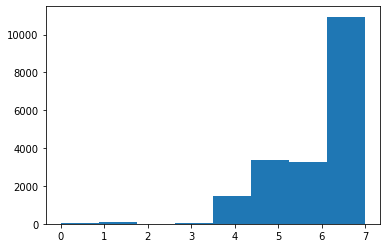

In [22]:
plt.hist([v for _,v in races_to_codes.items()], bins=8)

In [23]:
num_races_has_rpr = cnts[4] + cnts[5] + cnts[6] + cnts[7]
num_races_has_rpr

19064

In [33]:
num_races_has_tr = cnts[2] + cnts[3] + cnts[6] + cnts[7]
num_races_has_tr

14261

In [34]:
num_races_has_or = cnts[1] + cnts[3] + cnts[5] + cnts[7]
num_races_has_or

14413

Again, these values look largely good.

At this point, I had a revelation. For races where there is no `RPR`/ `OR`/ `TR` information across the entire race, we can simply fill this in with _any_ value, in particular the global average. For races where there is `RPR`/`OR`/`TR` information, this is when we have to use the average for that race.

---

## Get Average Per Race

In [35]:
average_by_race = {}

for rid in tqdm(races_featurized['rid']):
    df = horses_all_working[horses_all_working['rid'] == rid]
    rprs = df[~ df['RPR'].isnull()]['RPR']
    trs = df[~ df['TR'].isnull()]['TR']
    ors = df[~ df['OR'].isnull()]['OR']
    rpr_mean = np.mean(rprs) if len(rprs) > 0 else float('nan')
    tr_mean = np.mean(trs) if len(trs) > 0 else float('nan')
    or_mean = np.mean(ors) if len(ors) > 0 else float('nan')
    average_by_race[rid] = {
        'RPR': rpr_mean,
        'TR': tr_mean,
        'OR': or_mean,
    }

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19248/19248 [00:37<00:00, 518.09it/s]


In [36]:
df = races_featurized[races_featurized['rid'].isin([340707, 119056, 20624, 126967, 405768])]
df

,rid,metric,margin,temp,msl,rain,rhum,course__Ballinrobe,course__Bellewstown,course__Clonmel,...,month__4,month__5,month__6,month__7,month__8,month__9,month__10,month__11,month__12,year
1065,119056,4524.5,1.299824,7.6,1004.7,0.0,60,0,0,0,...,0,0,0,0,0,0,1,0,0,2018
1460,126967,2011.0,1.147759,16.4,1035.4,0.0,44,0,0,0,...,0,1,0,0,0,0,0,0,0,2019
3375,405768,1206.0,1.083150,24.9,1018.6,0.0,36,0,0,0,...,0,0,1,0,0,0,0,0,0,2020
7293,20624,1609.0,1.633339,16.7,1031.3,0.0,64,0,0,0,...,0,0,0,0,1,0,0,0,0,2007
11178,340707,2413.0,1.334584,16.1,1012.7,0.0,87,0,0,0,...,0,0,1,0,0,0,0,0,0,2004


In [37]:
horses_all_working[horses_all_working['rid'] == 340707]

,rid,horseName,RPR,TR,OR
115413,340707,Urban,79.0,NaN,72.0
115414,340707,Taxing Times,62.0,NaN,60.0
115415,340707,Orange Blossom,64.0,NaN,63.0
115416,340707,Grable,67.0,NaN,68.0
115417,340707,Cliste,66.0,NaN,68.0
115418,340707,Spanish Cove,58.0,NaN,60.0
115419,340707,Norborne Bandit,69.0,NaN,74.0
115420,340707,Wood Road,52.0,NaN,58.0
115421,340707,Foolish Guest,54.0,NaN,61.0
115422,340707,Icarus Dream,55.0,NaN,72.0


In [38]:
[races_to_codes[rid] for rid in df['rid']]

[5, 7, 6, 7, 5]

In [39]:
[average_by_race[rid] for rid in df['rid']]

[{'RPR': 77.81818181818181, 'TR': nan, 'OR': 89.46153846153847},
 {'RPR': 101.85714285714286,
  'TR': 69.57142857142857,
  'OR': 100.83333333333333},
 {'RPR': 76.4, 'TR': 74.6, 'OR': nan},
 {'RPR': 62.38461538461539, 'TR': 56.38461538461539, 'OR': 67.35714285714286},
 {'RPR': 59.0, 'TR': nan, 'OR': 65.33333333333333}]

---

## Fill in Values Using Averages by Race

In [40]:
for idx, row in tqdm(horses_all_working.iterrows()):
    if pd.isna(row['RPR']):
        horses_all_working.at[idx, 'RPR'] = average_by_race[row['rid']]['RPR']
    if pd.isna(row['TR']):
        horses_all_working.at[idx, 'TR'] = average_by_race[row['rid']]['TR']
    if pd.isna(row['OR']):
        horses_all_working.at[idx, 'OR'] = average_by_race[row['rid']]['OR']

194573it [00:11, 16538.36it/s]


In [52]:
horses_all_working[horses_all_working['rid'] == 302858]

,rid,horseName,RPR,TR,OR
0,302858,Kings Return,102.0,NaN,NaN
1,302858,Majestic Red I,94.0,NaN,NaN
2,302858,Clearly Canadian,92.0,NaN,NaN
3,302858,Bernestic Wonder,96.0,NaN,NaN
4,302858,Beauty's Pride,96.0,NaN,NaN
5,302858,Graignamanagh,96.0,NaN,NaN


---

## Fill In Remaining Values with Global Average

Now, we can fill in the remaining values with global averages.

First, RPR.

In [53]:
entries_nan_rpr = horses_all_working[
    horses_all_working['RPR'].isnull()
]
len(entries_nan_rpr)

1551

In [54]:
mean_rpr = np.mean(horses_all_working[~horses_all_working['RPR'].isnull()]['RPR'])
mean_rpr

65.79802665087581

In [55]:
horses_all_working['RPR'].fillna(mean_rpr, inplace=True)

In [56]:
entries_nan_rpr = horses_all_working[
    horses_all_working['RPR'].isnull()
]
assert len(entries_nan_rpr) == 0

Now, TR.

In [57]:
entries_nan_tr = horses_all_working[
    horses_all_working['TR'].isnull()
]
len(entries_nan_tr)

50208

In [58]:
mean_tr = np.mean(horses_all_working[~horses_all_working['TR'].isnull()]['TR'])
mean_tr

42.0515166334068

In [59]:
horses_all_working['TR'].fillna(mean_tr, inplace=True)

In [60]:
entries_nan_tr = horses_all_working[
    horses_all_working['TR'].isnull()
]
assert len(entries_nan_tr) == 0

Finally, OR.

In [61]:
entries_nan_or = horses_all_working[
    horses_all_working['OR'].isnull()
]
len(entries_nan_or)

46486

In [62]:
mean_or = np.mean(horses_all_working[~horses_all_working['OR'].isnull()]['OR'])
mean_or

73.64167568200114

In [63]:
horses_all_working['OR'].fillna(mean_or, inplace=True)

In [64]:
entries_nan_or = horses_all_working[
    horses_all_working['OR'].isnull()
]
assert len(entries_nan_or) == 0

---

## Sanity Check

In [66]:
assert len(horses_all_working[
    horses_all_working['RPR'].isnull() |
    horses_all_working['TR'].isnull() |
    horses_all_working['OR'].isnull()
]) == 0

In [68]:
horses_all_working.head()

,rid,horseName,RPR,TR,OR
0,302858,Kings Return,102.0,42.051517,73.641676
1,302858,Majestic Red I,94.0,42.051517,73.641676
2,302858,Clearly Canadian,92.0,42.051517,73.641676
3,302858,Bernestic Wonder,96.0,42.051517,73.641676
4,302858,Beauty's Pride,96.0,42.051517,73.641676


---

## Save Dataframes

In [67]:
horses_all_working.to_csv(f"{BASE_DIR}/data/csv/horses_true_rpr_tr_or.csv", index=False)

---